In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

from armored.models import *
from armored.preprocessing import *

from sklearn.model_selection import KFold

import itertools
import re

from tqdm import tqdm

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Teal
    "#9edae5",  # Light Blue
    "#c7c7c7",  # Light Gray
    "#c49c94",  # Light Red
    "#98df8a",  # Light Green
    "#f7b6d2"   # Light Pink
]

In [2]:
# import community data
df_comm = pd.read_csv("Data/arc_allcomm.csv")

# import monoculture data
df_mono = pd.read_csv("Data/arc_allmono.csv")

# combine data for Fit
df = pd.concat((df_comm, df_mono))

# define species and pH
species = ['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 
           'CC_OD', 'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD']
controls = []
metabolites = ['pH']

# concatenate all observed and all system variables 
observed = np.concatenate((np.array(species), np.array(metabolites)))
system_variables = np.concatenate((np.array(species), np.array(metabolites), np.array(controls)))
system_variables

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD', 'pH'],
      dtype='<U32')

# K fold cross-validation

In [3]:
# number of folds
n_splits = 10
        
# df for training 
all_treatments = np.array([exp.split("_")[0] for exp in df.Experiments.values])
unique_treatments = np.unique(all_treatments) 

kf = KFold(n_splits=n_splits, shuffle=True, random_state=123)
k_fold_df = pd.DataFrame()
for i, (train_index, test_index) in enumerate(kf.split(unique_treatments)):

    # split into train and test
    train_index = np.in1d(all_treatments, unique_treatments[train_index])
    test_index  = np.in1d(all_treatments, unique_treatments[test_index])
    train_df = df.iloc[train_index].copy()

    # average replicates in train set for fitting data transform
    train_df_copy = df.iloc[train_index].copy()
    train_df_copy['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in train_df_copy.Experiments.values]
    train_df_avg = []
    for exp_name, df_exp in train_df_copy.groupby("Experiments"):
        df_groups = df_exp.groupby("Time")
        df_avg = df_groups[system_variables].mean().reset_index()
        df_avg.insert(0, "Experiments", [exp_name]*df_avg.shape[0])
        train_df_avg.append(df_avg)
    train_df_avg = pd.concat(train_df_avg)

    # average replicates in test set
    df_test  = df.iloc[test_index].copy() 
    df_test['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in df_test.Experiments.values]
    df_test_mean = []
    for exp_name, df_exp in df_test.groupby("Experiments"):
        df_groups = df_exp.groupby("Time")
        df_avg = df_groups[system_variables].mean().reset_index()
        df_avg.insert(0, "Experiments", [exp_name]*df_avg.shape[0])
        df_test_mean.append(df_avg)
    test_df = pd.concat(df_test_mean)
    
    # scale data 
    scaler = MinMaxScaler(observed, system_variables)
    scaler.fit(train_df_avg)
    train_df_scaled = scaler.transform(train_df.copy())
    test_df_scaled = scaler.transform(test_df.copy())

    # format data into matrix [n_samples, n_timepoints, dt+n_outputs+n_controls]
    train_data = format_data(train_df, species, metabolites, controls, observed=observed)
    train_data_scaled = format_data(train_df_scaled, species, metabolites, controls, observed=observed)
    test_data = format_data(test_df, species, metabolites, controls, observed=observed)
    test_data_scaled = format_data(test_df_scaled, species, metabolites, controls, observed=observed)

    # instantiate model
    brnn = miRNN(n_species=len(species), 
                 n_metabolites=len(metabolites), 
                 n_controls=len(controls), 
                 n_hidden=16)

    # fit model
    brnn.fit(train_data_scaled, 
             alpha_0=1., 
             evd_tol=1e-3)

    # make predictions
    predictions = scaler.inverse_transform(brnn.predict(test_data_scaled))

    # save predictions
    pred_df = pd.DataFrame()
    for (T, X, U, Y, exp_names), (_, preds, stdvs, exp_names_pred) in zip(test_data, predictions):

        # save species predictions for each experimental condition
        for i, exp_name in enumerate(exp_names):
            # init dataframe
            pred_df_exp = pd.DataFrame()

            # insert exp name
            pred_df_exp["Experiments"] = [exp_name]*len(T[i])
            pred_df_exp["Time"] = T[i]

            for j, s in enumerate(observed):
                pred_df_exp[s + " true"] = Y[i,:,j]
                pred_df_exp[s + " pred"] = preds[i,:,j]
                pred_df_exp[s + " stdv"] = stdvs[i,:,j]

            # append to test prediction dataframe
            pred_df = pd.concat((pred_df, pred_df_exp))
    k_fold_df = pd.concat((k_fold_df, pred_df))
    k_fold_df.to_csv(f"kfold/mirnn/10_fold_MiRNN.csv", index=False)

Total measurements: 5617, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1057.834, Residuals: -0.00320
Loss: 1005.160, Residuals: -0.02457
Loss: 930.363, Residuals: -0.01653
Loss: 890.602, Residuals: -0.00156
Loss: 864.210, Residuals: -0.00058
Loss: 814.293, Residuals: -0.01193
Loss: 796.300, Residuals: 0.00095
Loss: 656.739, Residuals: -0.00276
Loss: 645.945, Residuals: 0.00242
Loss: 603.039, Residuals: 0.00448
Loss: 598.088, Residuals: -0.00128
Loss: 564.262, Residuals: 0.00695
Loss: 560.144, Residuals: 0.00169
Loss: 552.324, Residuals: 0.00171
Loss: 537.662, Residuals: 0.00136
Loss: 514.997, Residuals: 0.00351
Loss: 511.727, Residuals: 0.00042
Loss: 505.870, Residuals: 0.00056
Loss: 497.753, Residuals: 0.00131
Loss: 487.520, Residuals: 0.00409
Loss: 485.523, Residuals: 0.00085
Loss: 481.763, Residuals: 0.00083
Loss: 476.449, Residuals: 0.00126
Loss: 471.361, Residuals: 0.00274
Loss: 467.356, Residuals: 0.00188
Loss: 465.911, Residuals: 0.00052
Loss: 463.193, Resid

2024-08-14 20:22:21.659047: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed
2024-08-14 20:22:22.197806: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5672, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1040.893, Residuals: -0.00436
Loss: 987.347, Residuals: -0.02570
Loss: 912.324, Residuals: -0.01645
Loss: 875.607, Residuals: -0.00139
Loss: 855.053, Residuals: 0.00430
Loss: 844.470, Residuals: -0.00406
Loss: 760.955, Residuals: -0.01552
Loss: 735.354, Residuals: -0.00132
Loss: 644.532, Residuals: -0.00344
Loss: 592.977, Residuals: -0.00145
Loss: 570.843, Residuals: 0.00501
Loss: 563.493, Residuals: 0.00354
Loss: 553.890, Residuals: 0.00028
Loss: 536.893, Residuals: 0.00090
Loss: 511.051, Residuals: -0.00170
Loss: 510.399, Residuals: 0.00004
Loss: 504.596, Residuals: 0.00034
Loss: 495.507, Residuals: 0.00048
Loss: 482.634, Residuals: 0.00065
Loss: 476.703, Residuals: 0.00115
Loss: 473.584, Residuals: -0.00008
Loss: 472.483, Residuals: -0.00076
Loss: 470.526, Residuals: -0.00076
Loss: 466.938, Residuals: -0.00073
Loss: 461.171, Residuals: -0.00064
Loss: 455.439, Residuals: -0.00027
Loss: 453.137

2024-08-14 20:23:45.037776: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed
2024-08-14 20:23:45.465017: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5583, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1055.123, Residuals: -0.00742
Loss: 998.506, Residuals: -0.02780
Loss: 917.628, Residuals: -0.01833
Loss: 872.758, Residuals: 0.00564
Loss: 839.642, Residuals: 0.00299
Loss: 836.889, Residuals: -0.00117
Loss: 757.277, Residuals: -0.01147
Loss: 733.868, Residuals: 0.00224
Loss: 645.785, Residuals: 0.00228
Loss: 644.358, Residuals: -0.00056
Loss: 631.336, Residuals: -0.00026
Loss: 608.261, Residuals: -0.00025
Loss: 599.583, Residuals: 0.00105
Loss: 553.350, Residuals: 0.00435
Loss: 547.319, Residuals: -0.00095
Loss: 535.933, Residuals: -0.00068
Loss: 516.074, Residuals: -0.00002
Loss: 490.511, Residuals: 0.00026
Loss: 479.778, Residuals: 0.00199
Loss: 474.259, Residuals: 0.00231
Loss: 473.268, Residuals: 0.00021
Loss: 471.780, Residuals: 0.00037
Loss: 469.452, Residuals: 0.00041
Loss: 467.220, Residuals: 0.00061
Loss: 464.227, Residuals: 0.00113
Loss: 461.392, Residuals: 0.00139
Loss: 460.706, Res

2024-08-14 20:25:09.015274: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5601, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1080.056, Residuals: -0.00474
Loss: 1012.201, Residuals: -0.02771
Loss: 922.864, Residuals: -0.01546
Loss: 890.662, Residuals: 0.00153
Loss: 866.109, Residuals: 0.00187
Loss: 805.220, Residuals: -0.01015
Loss: 785.519, Residuals: 0.00356
Loss: 691.545, Residuals: 0.00765
Loss: 683.137, Residuals: 0.00035
Loss: 643.128, Residuals: 0.00038
Loss: 593.283, Residuals: 0.00104
Loss: 586.562, Residuals: -0.00434
Loss: 576.845, Residuals: 0.00021
Loss: 559.850, Residuals: -0.00010
Loss: 549.583, Residuals: 0.00863
Loss: 544.401, Residuals: 0.00331
Loss: 540.157, Residuals: 0.00072
Loss: 532.056, Residuals: 0.00059
Loss: 518.162, Residuals: -0.00029
Loss: 516.024, Residuals: -0.00004
Loss: 512.016, Residuals: -0.00002
Loss: 504.792, Residuals: -0.00018
Loss: 495.843, Residuals: 0.00016
Loss: 490.835, Residuals: -0.00126
Loss: 490.428, Residuals: -0.00238
Loss: 486.737, Residuals: -0.00203
Loss: 481.802, 

2024-08-14 20:26:40.543729: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5612, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1040.454, Residuals: -0.00732
Loss: 971.722, Residuals: -0.02922
Loss: 880.069, Residuals: -0.01683
Loss: 867.785, Residuals: -0.00834
Loss: 846.658, Residuals: -0.00670
Loss: 802.163, Residuals: -0.00889
Loss: 796.878, Residuals: -0.00125
Loss: 727.159, Residuals: -0.01158
Loss: 711.465, Residuals: 0.00040
Loss: 630.097, Residuals: -0.00487
Loss: 628.385, Residuals: -0.00163
Loss: 625.283, Residuals: -0.00158
Loss: 595.722, Residuals: 0.00042
Loss: 594.176, Residuals: -0.00270
Loss: 579.947, Residuals: -0.00246
Loss: 552.618, Residuals: -0.00221
Loss: 529.201, Residuals: 0.00464
Loss: 522.320, Residuals: 0.00635
Loss: 518.911, Residuals: 0.00110
Loss: 513.142, Residuals: 0.00107
Loss: 503.570, Residuals: 0.00007
Loss: 498.725, Residuals: 0.00167
Loss: 493.433, Residuals: 0.00240
Loss: 493.139, Residuals: 0.00107
Loss: 490.719, Residuals: 0.00120
Loss: 487.150, Residuals: 0.00124
Loss: 486.383, 

2024-08-14 20:28:07.934506: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5583, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1030.615, Residuals: -0.00827
Loss: 977.294, Residuals: -0.02770
Loss: 899.978, Residuals: -0.01890
Loss: 855.785, Residuals: -0.00142
Loss: 804.488, Residuals: -0.00397
Loss: 658.712, Residuals: 0.01015
Loss: 631.716, Residuals: -0.00220
Loss: 586.356, Residuals: -0.00124
Loss: 574.317, Residuals: -0.00073
Loss: 552.018, Residuals: -0.00002
Loss: 514.928, Residuals: -0.00064
Loss: 511.708, Residuals: 0.00121
Loss: 485.921, Residuals: -0.00131
Loss: 481.647, Residuals: 0.00012
Loss: 476.797, Residuals: 0.00023
Loss: 467.425, Residuals: 0.00021
Loss: 465.807, Residuals: 0.00110
Loss: 462.875, Residuals: 0.00099
Loss: 462.334, Residuals: -0.00006
Loss: 458.847, Residuals: 0.00018
Loss: 455.374, Residuals: 0.00133
Loss: 452.904, Residuals: 0.00151
Loss: 450.119, Residuals: 0.00172
Loss: 449.949, Residuals: 0.00216
Loss: 449.645, Residuals: 0.00171
Loss: 449.072, Residuals: 0.00163
Loss: 448.152, Re

2024-08-14 20:29:33.679309: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 4715, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 737.791, Residuals: -0.00734
Loss: 693.968, Residuals: -0.02321
Loss: 627.196, Residuals: -0.01568
Loss: 582.636, Residuals: 0.00303
Loss: 575.672, Residuals: 0.00422
Loss: 511.353, Residuals: -0.00616
Loss: 498.969, Residuals: 0.00147
Loss: 401.023, Residuals: -0.00089
Loss: 393.937, Residuals: -0.00043
Loss: 381.498, Residuals: -0.00032
Loss: 359.201, Residuals: -0.00049
Loss: 336.997, Residuals: 0.00035
Loss: 335.426, Residuals: -0.00168
Loss: 332.951, Residuals: -0.00117
Loss: 328.321, Residuals: -0.00089
Loss: 309.975, Residuals: 0.00162
Loss: 306.211, Residuals: -0.00020
Loss: 301.083, Residuals: 0.00003
Loss: 292.484, Residuals: -0.00026
Loss: 289.376, Residuals: -0.00156
Loss: 285.967, Residuals: -0.00037
Loss: 281.694, Residuals: -0.00029
Loss: 278.425, Residuals: 0.00071
Loss: 271.949, Residuals: 0.00034
Loss: 264.246, Residuals: 0.00103
Loss: 261.005, Residuals: -0.00028
Loss: 259.650

Loss: 2343.494, Residuals: -0.00041
Updating precision...
Evidence 6880.022
Pass count  1


2024-08-14 20:31:54.926764: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5599, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1027.019, Residuals: -0.00671
Loss: 964.803, Residuals: -0.02787
Loss: 879.032, Residuals: -0.01735
Loss: 864.552, Residuals: -0.00839
Loss: 841.183, Residuals: -0.00639
Loss: 795.557, Residuals: -0.01536
Loss: 772.779, Residuals: 0.00037
Loss: 635.690, Residuals: 0.00417
Loss: 625.726, Residuals: -0.00372
Loss: 607.572, Residuals: -0.00299
Loss: 572.743, Residuals: -0.00182
Loss: 545.417, Residuals: 0.00194
Loss: 535.932, Residuals: 0.00183
Loss: 518.171, Residuals: 0.00187
Loss: 491.145, Residuals: 0.00143
Loss: 478.979, Residuals: 0.00468
Loss: 476.993, Residuals: 0.00125
Loss: 473.122, Residuals: 0.00137
Loss: 466.291, Residuals: 0.00160
Loss: 457.533, Residuals: 0.00193
Loss: 451.730, Residuals: 0.00283
Loss: 447.391, Residuals: 0.00342
Loss: 445.065, Residuals: 0.00335
Loss: 441.594, Residuals: 0.00332
Loss: 441.104, Residuals: 0.00208
Loss: 440.157, Residuals: 0.00118
Loss: 438.289, Resid

2024-08-14 20:33:41.666934: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5638, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1034.002, Residuals: -0.00283
Loss: 978.136, Residuals: -0.02624
Loss: 900.608, Residuals: -0.01740
Loss: 864.075, Residuals: -0.00125
Loss: 841.614, Residuals: 0.00191
Loss: 783.102, Residuals: -0.01173
Loss: 769.818, Residuals: 0.00026
Loss: 622.812, Residuals: -0.00093
Loss: 600.965, Residuals: 0.00186
Loss: 561.920, Residuals: 0.00236
Loss: 559.916, Residuals: -0.00092
Loss: 541.379, Residuals: 0.00029
Loss: 512.705, Residuals: 0.00227
Loss: 511.426, Residuals: -0.00027
Loss: 499.831, Residuals: -0.00011
Loss: 483.242, Residuals: 0.00129
Loss: 479.872, Residuals: -0.00084
Loss: 476.058, Residuals: -0.00015
Loss: 468.911, Residuals: 0.00056
Loss: 468.517, Residuals: 0.00129
Loss: 467.911, Residuals: 0.00025
Loss: 463.278, Residuals: 0.00061
Loss: 463.161, Residuals: 0.00225
Loss: 462.940, Residuals: 0.00193
Loss: 462.563, Residuals: 0.00128
Loss: 459.913, Residuals: 0.00142
Loss: 457.599, Res

Loss: 2731.562, Residuals: -0.00037
Loss: 2731.058, Residuals: -0.00038
Loss: 2728.684, Residuals: -0.00035
Loss: 2724.664, Residuals: -0.00034
Loss: 2716.811, Residuals: -0.00034
Loss: 2711.944, Residuals: -0.00029
Loss: 2711.636, Residuals: -0.00029
Updating precision...
Evidence 7179.812
Updating precision...
Evidence 7190.918
Updating precision...
Evidence 7192.416
Pass count  1


2024-08-14 20:36:04.130860: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed
2024-08-14 20:36:04.516992: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5770, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1060.315, Residuals: -0.00798
Loss: 1003.168, Residuals: -0.02689
Loss: 920.949, Residuals: -0.01784
Loss: 881.342, Residuals: -0.00411
Loss: 863.016, Residuals: -0.00280
Loss: 817.582, Residuals: -0.01014
Loss: 803.303, Residuals: 0.00111
Loss: 627.682, Residuals: 0.00140
Loss: 624.382, Residuals: -0.00280
Loss: 618.116, Residuals: -0.00258
Loss: 606.669, Residuals: -0.00189
Loss: 589.226, Residuals: -0.00034
Loss: 558.014, Residuals: 0.00166
Loss: 555.773, Residuals: -0.00152
Loss: 552.050, Residuals: -0.00023
Loss: 545.508, Residuals: -0.00009
Loss: 533.892, Residuals: 0.00017
Loss: 525.179, Residuals: 0.00496
Loss: 522.293, Residuals: 0.00135
Loss: 516.689, Residuals: 0.00140
Loss: 508.088, Residuals: 0.00163
Loss: 493.874, Residuals: 0.00113
Loss: 476.592, Residuals: 0.00202
Loss: 474.743, Residuals: -0.00023
Loss: 472.512, Residuals: 0.00006
Loss: 469.251, Residuals: 0.00018
Loss: 466.301,

2024-08-14 20:37:25.986034: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


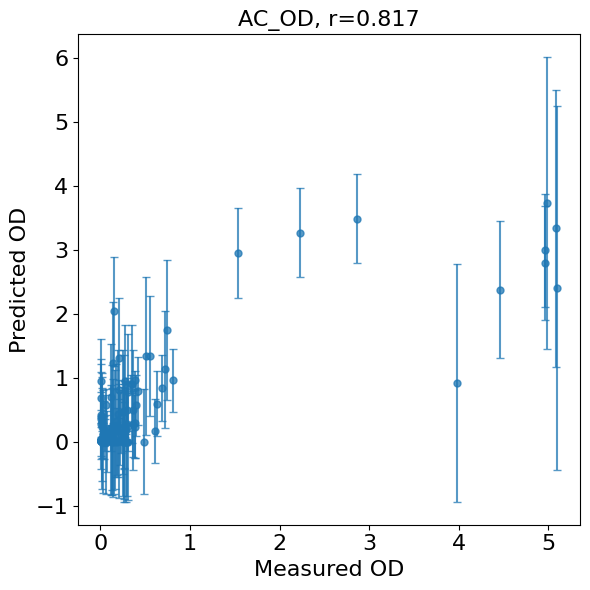

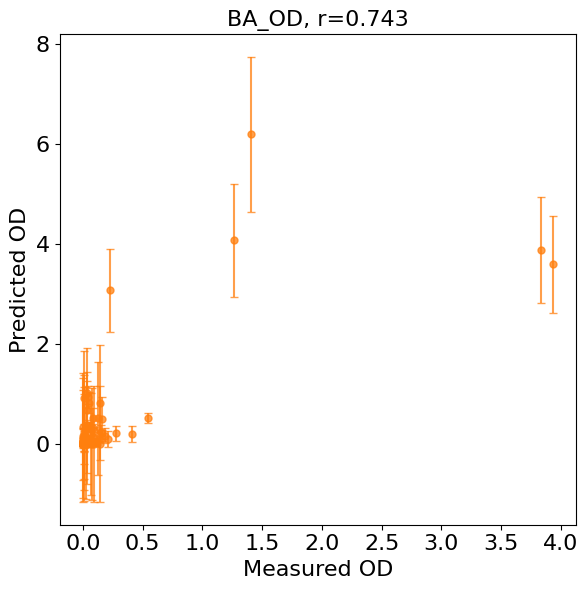

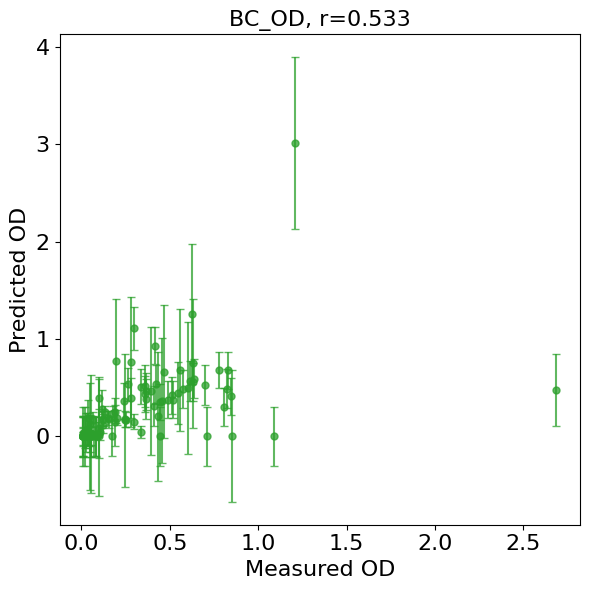

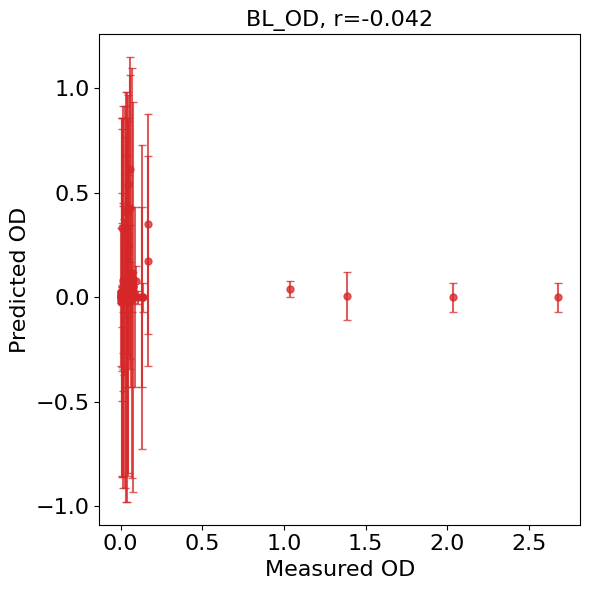

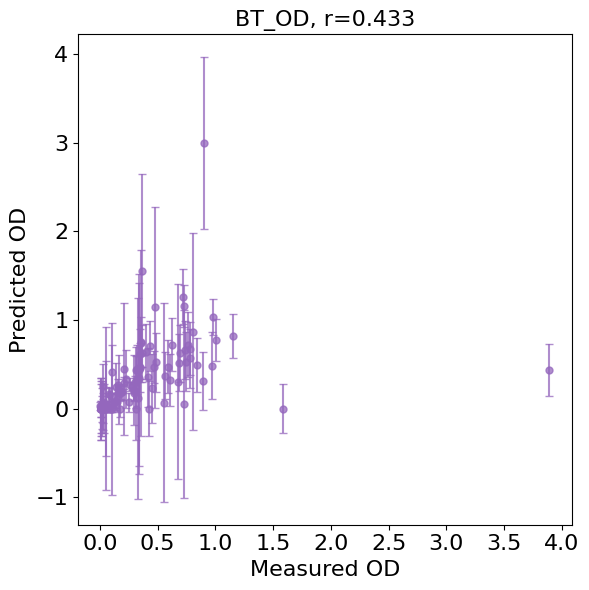

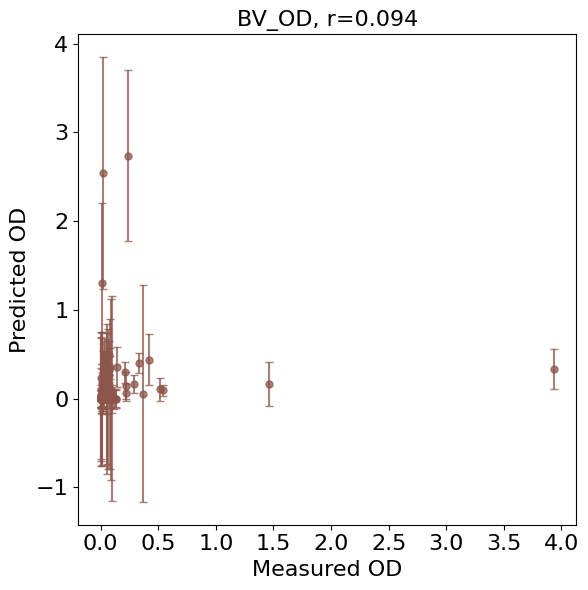

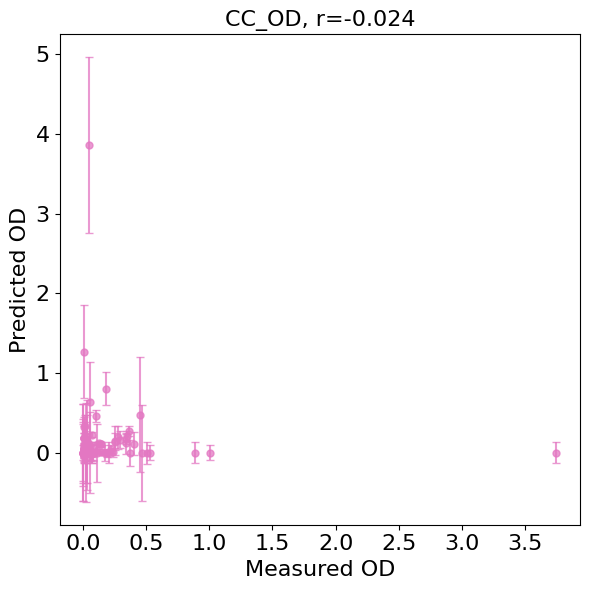

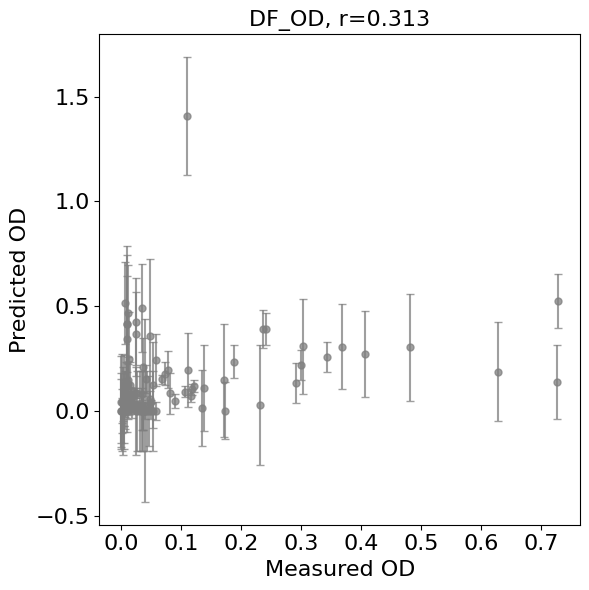

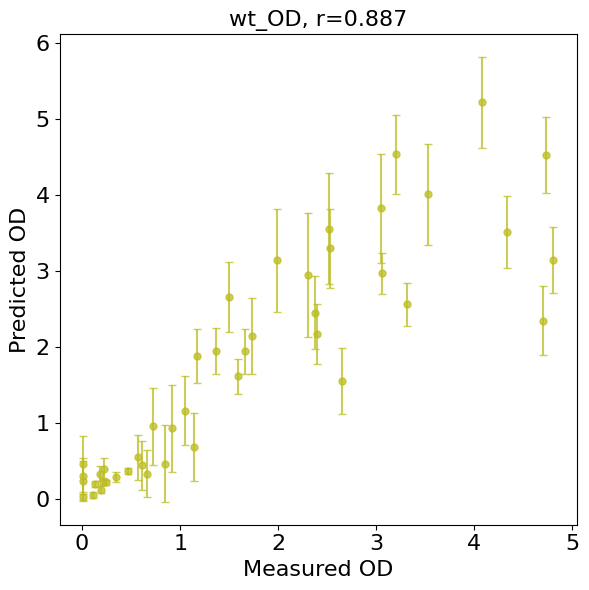

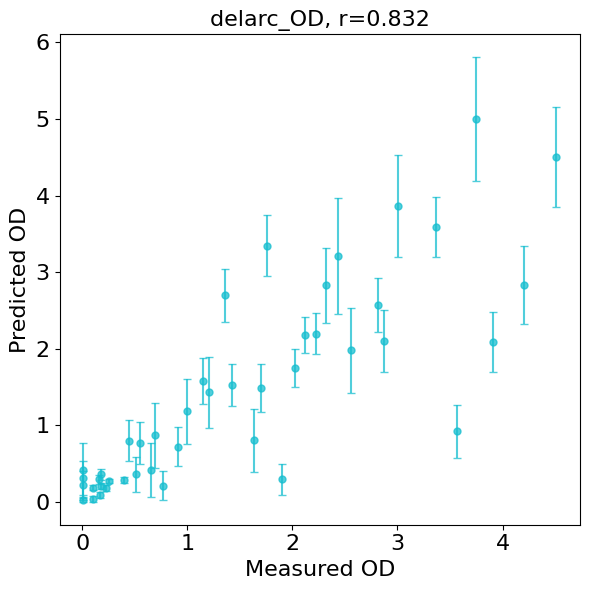

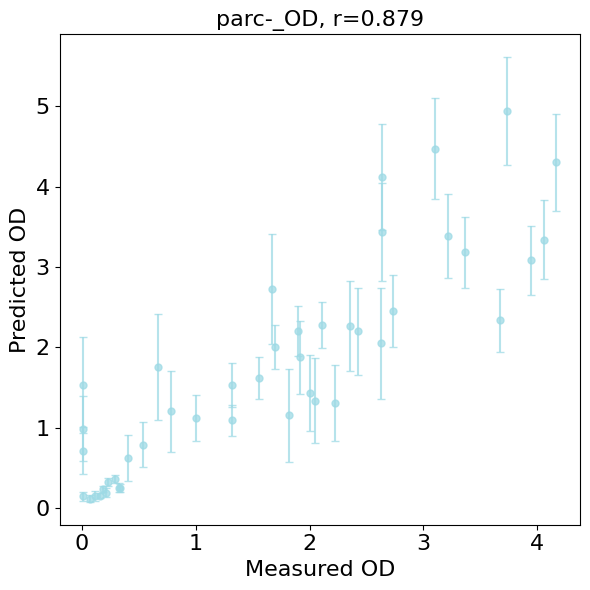

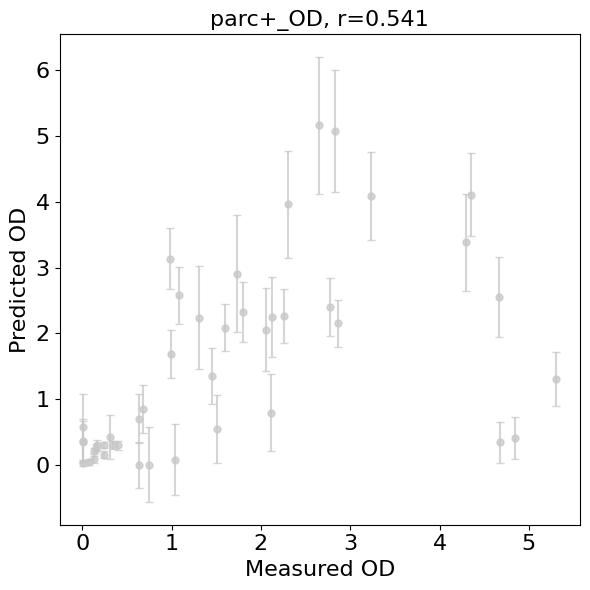

In [4]:
# import kfold results
r_vals = []
mse_vals = []
nll_vals = []

for i, obs in enumerate(species):
    plt.figure(figsize=(6, 6))
    
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in k_fold_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if species was inoculated        
        if true_vals_exp[0] > 0:
            # if not nan
            for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
                if not np.isnan(true_val_exp):
                    true_vals.append(true_val_exp)
                    pred_vals.append(pred_val_exp)
                    stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    # compute stats
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    
    # plot
    plt.errorbar(true_vals, pred_vals, yerr=stdv_vals, 
                 fmt='.', capsize=3, markersize=10, c=colors[i], alpha=.75)
    plt.title(f'{obs}, r={R:.3f}', fontsize=16)
    plt.xlabel("Measured OD", fontsize=16)
    plt.ylabel("Predicted OD", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"Figures/mirnn/{obs}_10fold.pdf")
    plt.show()

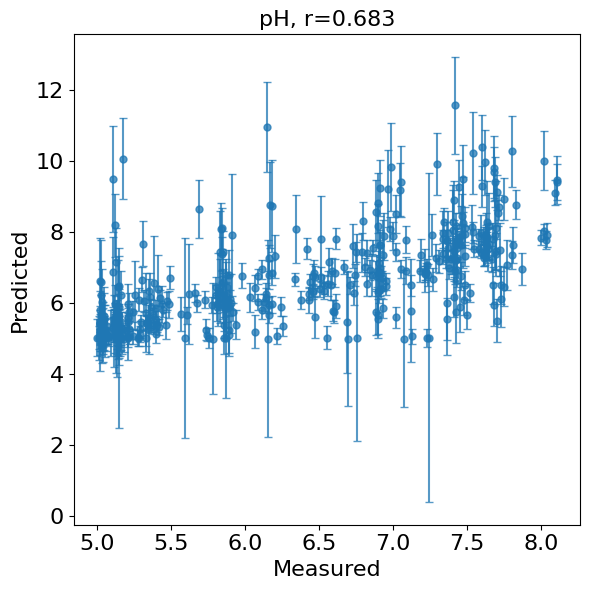

In [5]:
# import kfold results
r_vals = []
mse_vals = []
nll_vals = []


for i, obs in enumerate(metabolites):
    plt.figure(figsize=(6, 6))
    
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in k_fold_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if not nan
        for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
            if not np.isnan(true_val_exp):
                true_vals.append(true_val_exp)
                pred_vals.append(pred_val_exp)
                stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    # compute stats
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    
    # plot
    plt.errorbar(true_vals, pred_vals, yerr=stdv_vals, 
                 fmt='.', capsize=3, markersize=10, c=colors[i], alpha=.75)
    plt.title(f'{obs}, r={R:.3f}', fontsize=16)
    plt.xlabel("Measured", fontsize=16)
    plt.ylabel("Predicted", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"Figures/mirnn/{obs}_10fold.pdf")
    plt.show()